# Navier Stokes Equation Reduced Basis Method 
Incompressible timedependet Navier Stokes equation

Find $(u,p):[0,T] \to (H_{0,D}^1)^d \times L^2$, s.t.

\begin{align}
\int_{\Omega} \partial_t u \cdot v + \int_{\Omega} \nu \nabla u \nabla v + u \cdot \nabla u v - \int_{\Omega} \operatorname{div}(v) p &= \int f v  && \forall v \in (H_{0,D}^1)^d, \\ 
- \int_{\Omega} \operatorname{div}(u) q &= 0 && \forall q \in L^2, \\
\quad u(t=0) & = u_0
\end{align}

In [1]:
from netgen import gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
import scipy.sparse as sp
import numpy as np
from math import pi

In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3)
Draw(mesh)
# viscosity
nu = 0.001
dt = 0.001

T = 1
dn = int(T/dt)
z = 100  # Number of snapshots

In [3]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = FESpace([V,Q])

In [4]:
gfu_N = GridFunction(X)
gfu = GridFunction(X)
velocity = gfu.components[0]


uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

Draw(gfu.components[0],mesh,"gfu",sd=3)

In [5]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

In [6]:
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)

mstar += InnerProduct(u,v)*dx + dt*stokes

mstar.Assemble()

mh = BilinearForm(X)

mh += InnerProduct(u,v)*dx
mh.Assemble()

inv = mstar.mat.Inverse(X.FreeDofs())


conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [7]:
rows,cols,vals = a.mat.COO()
Ah = sp.csr_matrix((vals,(rows,cols)))
Fh = f.vec
rows,cols,vals = mh.mat.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))

In [8]:
t = 0
tend = 0
erg_h = np.zeros([len(gfu.vec),int(dn)+1])
conv_h = np.zeros([len(gfu.vec),int(dn)])
V = np.zeros([len(gfu.vec),z]) # creat the orthogonal transformationsmatrix for the reducebasis method
line = np.linspace(0,dn-1,z) # stors the number of linear distributed number of iteration from the solution
S_POD = np.zeros([len(gfu.vec),z])
#line = np.linspace(0,z,z) # stors the number of linear distributed number of iteration from the solution
#line

$
M\bigg(\frac{u^{n+1}-u^n}{k}\bigg) + A u^{n+1} +C u^{n} = 0
$

$
M^*\bigg(u^{n+1}-u^n\bigg) = -\Delta t A u^n - \Delta t Cu^n
$

$
M^* = M + \Delta tA 
$

In [9]:
# implicit Euler/explicit Euler splitting method:
V_sb = MultiVector(gfu.vec, 1)
V_sb[0] = gfu.vec
#V[:,0] = np.array(V_sb[0])
V[:,0] = np.array(V_sb[0])/np.linalg.norm(np.array(V_sb[0]))
erg_h[:,0] = gfu.vec
S_POD[:,0] = gfu.vec
tend += 1
o = 1
e = int(line[o])
for i in range(int(dn)):
    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res
    
    for r in line:
        if int(r) == i: #desided which solution will be orthogonalirsed
            if i > 0:
                #with TaskManager():
                #    V_sb.AppendOrthogonalize(gfu.vec)
                #V[:,o] = np.array(V_sb[o])
                S_POD[:,o] = gfu.vec
                o = o + 1
    erg_h[:,i+1] = gfu.vec #stores the solution for comparing later
    t = t + dt
    Redraw()

## POD method
A other way to get the transforamtions matrix is the POD method.
gifen $S = \{u_h^0,u_h^1,...u_h^{r-1}\}$ where $r$ ist the number of snapshots.

$
C_P = S^TS\\
C \in 
$

and solve the eigenwalueproblem
$
C_P\Omega = \Omega\Lambda
$

$
\phi_j = \frac{1}{\sqrt{\lambda_j}}S\omega_j
$
To get a orthogonal basis $V = \{\phi_0,...\phi_{r-1}\}$

In [10]:
def POD(S):
    V = np.zeros([len(gfu.vec),z])
    
    #splitting the snapshotsolution like in the paper
    #for i in range(S.shape[1]):
    #    S[:,i] = S[:,i] - 1/S.shape[0] * np.sum(S[:,i])
    
    if S.shape[1] <= S.shape[0]:
        C = np.transpose(S).dot(S)
        U, Sig, VH = np.linalg.svd(C, full_matrices=True)
        VH = np.transpose(VH)
        for i in range(C.shape[1]):
            V[:,i] = 1/np.sqrt(Sig[i]) * S.dot(VH[:,i])
        
        
    return V

In [11]:
V = POD(S_POD)
print(V[:,0].dot(V[:,z-1]))

-1.33744243110967e-10


$
M_N = V^TMV\\
A_N = V^TAV
$

In [12]:
MN = np.transpose(V).dot(Mh.dot(V))
AN = np.transpose(V).dot(Ah.dot(V))

In [13]:
gfu_N.vec.FV().NumPy()[:] = erg_h[:,0]
gfu.vec.FV().NumPy()[:] = erg_h[:,0]

uN = np.array(gfu_N.vec).dot(V)
velocity_N = gfu_N.components[0]
Draw(gfu_N.components[0],mesh,"gfu_N",sd=3)
Draw(gfu_N.components[0]-gfu.components[0],mesh,"error",sd=3)
err = res.CreateVector()
fom = res.CreateVector()
rom = res.CreateVector()

In [14]:
conv = LinearForm(X)
conv += InnerProduct(grad(velocity_N)*velocity_N,v)*dx

For the reduce IMEX solver we use the reduce matrixes. Where $C_N = V^TC$ to do it in every iteration step

$
M_N\bigg(\frac{u_N^{n+1}-u_N^n}{k}\bigg) + A_N u_N^{n+1} +C_N u_N^{n} = 0
$

$
M_N^*\bigg(u_N^{n+1}-u_N^n\bigg) = -\Delta t A_N u_N^n - \Delta t C_Nu_N^n
$

$
M^* = M_N + \Delta tA_N 
$

In [15]:
Residium = []
FOM_L2_norm = []
ROM_L2_norm = []
time = []
erg_N = np.zeros([len(gfu_N.vec),int(dn)+1])
erg_N[:,0] = gfu_N.vec

MN_star = MN + dt*AN
inv_N = np.linalg.inv(MN_star)
for i in range(int(dn)):
    err.vec = sqrt (Integrate ((gfu.components[0]-gfu_N.components[0])*(gfu.components[0]-gfu_N.components[0]),mesh))
    fom.vec = Integrate ((gfu.components[0])*(gfu.components[0]),mesh)
    rom.vec = Integrate ((gfu_N.components[0])*(gfu_N.components[0]),mesh)
    conv.Assemble()
    conv_N = np.transpose(V).dot(conv.vec)
    res_N = AN.dot(uN) + conv_N
    uN -= dt * inv_N.dot(res_N)
    erg_N[:,i+1] = (uN).dot(np.transpose(V))
    gfu.vec.FV().NumPy()[:] = erg_h[:,i+1]
    velocity_N = gfu_N.components[0]
    gfu_N.vec.FV().NumPy()[:] = (uN).dot(np.transpose(V))
    FOM_L2_norm.append(fom.vec)
    ROM_L2_norm.append(rom.vec)
    Residium.append(err.vec)
    time.append(dt*i)
    Redraw()

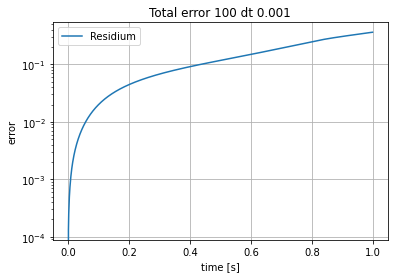

In [16]:
import matplotlib.pyplot as plt
plt.title("Total error {} dt {}".format(z,dt))
plt.ylabel("error")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,Residium, label='Residium')
plt.legend()
plt.savefig("plots/Total error {} dt POD".format(z))

In [17]:
FOM_L2_norm = []
ROM_L2_norm = []
Residium_N = []
for i in range(int(dn)):
    sum_h = sum(erg_h[:,i])
    sum_N = sum(erg_N[:,i])
    FOM_L2_norm.append(np.abs(sum_h*sum_h))
    ROM_L2_norm.append(np.abs(sum_N*sum_h))
    red = sum_N-sum_h
    Residium_N.append(np.sqrt(np.abs(red*red)))

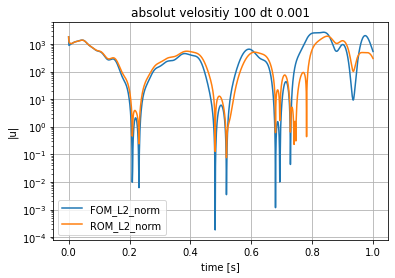

In [18]:
plt.title("absolut velositiy {} dt {}".format(z,dt))
plt.ylabel("|u|")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,FOM_L2_norm, label='FOM_L2_norm')
plt.semilogy(time,ROM_L2_norm, label='ROM_L2_norm')
plt.legend()
plt.savefig("plots/absolut velositiy {}".format(z))

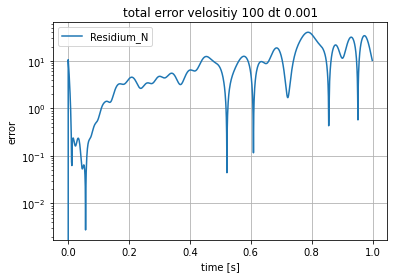

In [20]:
plt.title("total error velositiy {} dt {}".format(z,dt))
plt.ylabel("error")
plt.xlabel("time [s]")
plt.grid()
plt.semilogy(time,Residium_N, label='Residium_N')
plt.legend()
plt.savefig("plots/total error velositiy {}".format(z))